In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal

https://www.youtube.com/watch?v=RsRd6cLlbIk

- diffusion models （概率建模，Probabilistic perspective）
- denoising score matching
    - training
    - denoising

### score function

$$
s(x)=\nabla_x\log q(x)
$$

- w.r.t（关于） $x$ 的 gradient，与 $x$ 相同的 shape；
- 记 $q_{true}(x)$ 对应的 $s^*(x)=\nabla_x\log q_{true}(x)$
    - $x'=x+\eta s^*(x)$
        - gradient ascent，$x'$ 比着 $x$ 有着更高的 likelihood（关于 $q_{true}$）
- from a gaussion $\mathcal N(0, I)$, repeat
    - $x^{(k+\delta)}=x^{(k)}+\delta s^{*}(x^{(k)})$，会收敛到 $q_{true}$ 吗？

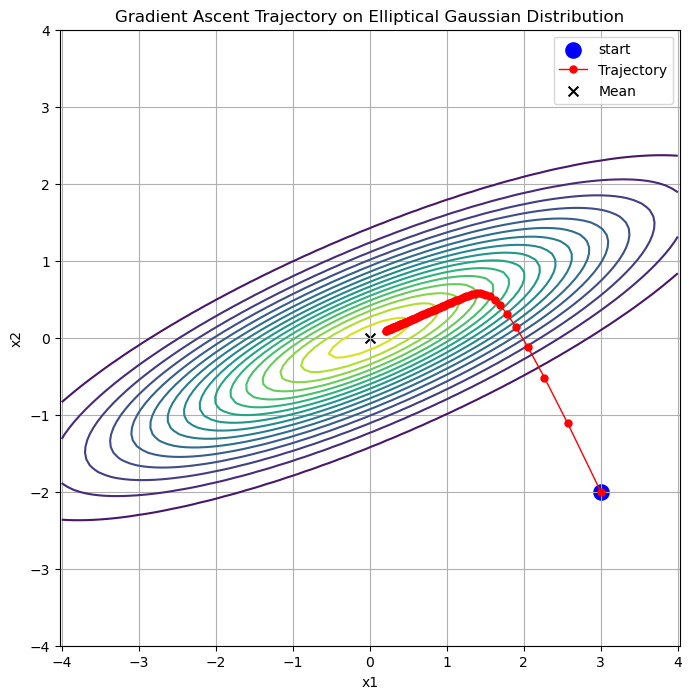

In [73]:
# Define the mean and covariance matrix
mu = np.array([0.0, 0.0])
sigma1 = 2.0
sigma2 = 1.0
rho = 0.8

Sigma = np.array([[sigma1**2, rho * sigma1 * sigma2],
                  [rho * sigma1 * sigma2, sigma2**2]])

# Compute the inverse of Sigma
Sigma_inv = np.linalg.inv(Sigma)

# Define the score function
def score_function(x):
    return -Sigma_inv @ (x - mu)

# Starting point
x0 = np.array([3.0, -2.0])

# Parameters
delta = 0.1  # Step size
num_iterations = 100

# Store the trajectory
trajectory = [x0]

x = x0.copy()
for _ in range(num_iterations):
    s = score_function(x)
    x = x + delta * s
    trajectory.append(x.copy())

trajectory = np.array(trajectory)

# Prepare grid for contour plot
x_grid = np.linspace(-4, 4, 100)
y_grid = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))

# Compute the Gaussian PDF
from scipy.stats import multivariate_normal
rv = multivariate_normal(mu, Sigma)
Z = rv.pdf(pos)

# Plotting
plt.figure(figsize=(8, 8))

plt.contour(X, Y, Z, levels=20, cmap='viridis')
# plt.contourf(X, Y, Z, levels=20, cmap='viridis')

plt.scatter(*trajectory[0],  marker='o', color='blue', s=120, label='start')
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color='red', label='Trajectory', ms=5, lw=1)
plt.scatter(mu[0], mu[1], color='black', marker='x', s=50, label='Mean')

plt.title('Gradient Ascent Trajectory on Elliptical Gaussian Distribution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

#### coding

- $q_{true}\propto \exp(-U(x))$, $U(x)=(\|x\|^2-1)^2$
    -  a ring-shaped distribution centered at the origin with a radius of 1.
- $s^*=\nabla_x\log q_{true}=-\nabla_xU(x)=-4(x_1^2+x_2^2-1)x$
    - 考虑1个2d的例子：$U(x)=(x_1^2+x_2^2-1)^2$，则有 $\nabla_xU(x)=2(\|x\|^2-1)\cdot 2x=2(x_1^2+x_2^2-1)\cdot 2x$（是一个2d的向量）
- Langevin Dynamics: add a tiny bit of noise at each step -> $Q_{true}$
    - $\sqrt{2\delta}\cdot\epsilon$: ensures exploration and convergence to the true distribution.
        - $\epsilon\sim\mathcal N(0, I)$
    - It prevents the samples from getting stuck in local maxima.
    - $x^{(k+\delta)}=x^{(k)}+\delta s^{*}(x^{(k)})+\sqrt{2\delta}\epsilon$
    - $\text{dist}(x^{\infty})\equiv Q_{true}$

In [48]:
# Define the potential function U(x) and q_true(x)
def U(x):
    return (np.sum(x**2, axis=-1) - 1)**2

def q_true(x):
    return np.exp(-U(x))

# Define the score function
def score_function(x):
    norm_sq = np.sum(x**2, axis=1, keepdims=True)
    return -4 * (norm_sq - 1) * x

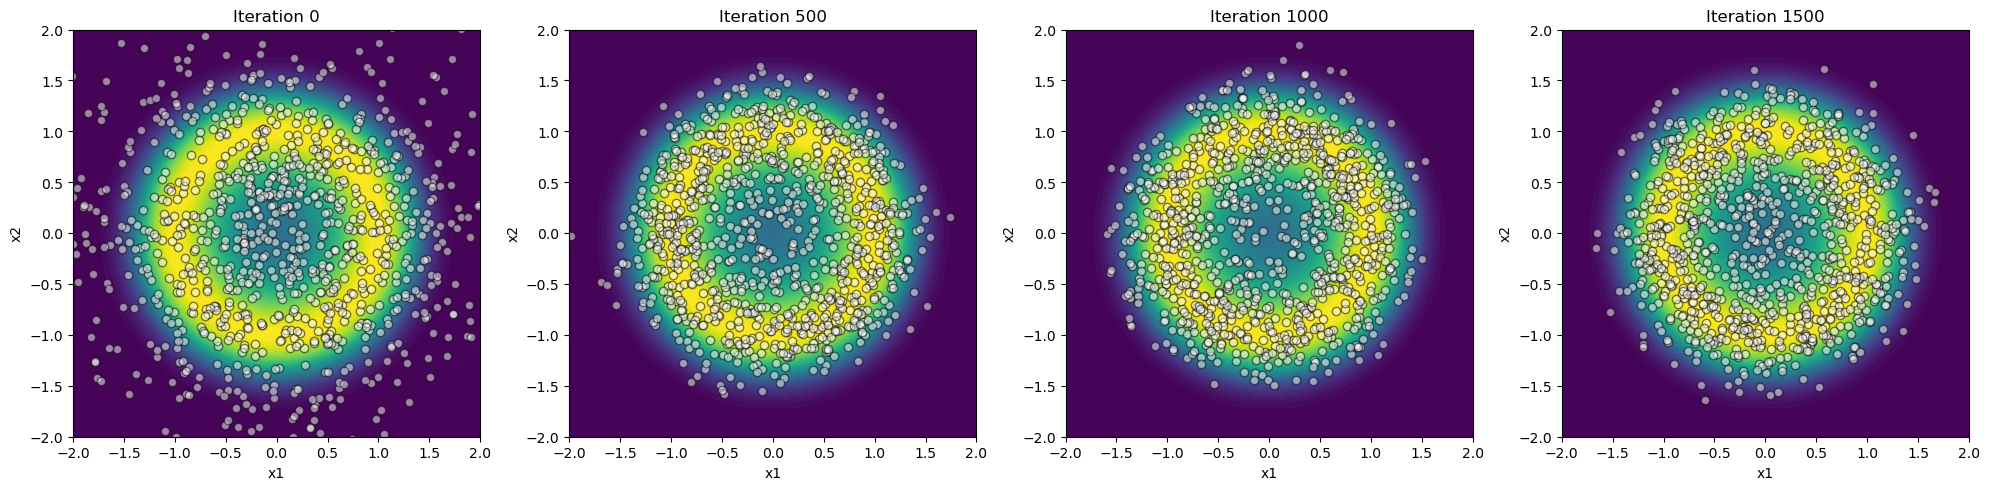

In [47]:
# Generate initial samples from N(0, I)
num_samples = 1000
x = np.random.randn(num_samples, 2)

# Parameters
delta = 0.01  # Step size
num_iterations = 500

# Prepare grid for plotting q_true(x)
x_grid = np.linspace(-3, 3, 200)
y_grid = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([X, Y], axis=-1)
Z = q_true(grid_points)

# Prepare for plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot initial samples with q_true(x)
axes[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axes[0].scatter(x[:, 0], x[:, 1], alpha=0.5, color='white', edgecolors='black')
axes[0].set_title('Iteration 0')

# Perform iterations
for i in range(1, 4):
    for _ in range(num_iterations):
        s = score_function(x)
        x += delta * s + np.sqrt(2 * delta) * np.random.randn(num_samples, 2)  # Langevin dynamics
        # x += delta * s
    
    # Plot samples at current iteration with q_true(x)
    axes[i].contourf(X, Y, Z, levels=50, cmap='viridis')
    axes[i].scatter(x[:, 0], x[:, 1], alpha=0.5, color='white', edgecolors='black')
    axes[i].set_title(f'Iteration {i * num_iterations}')

# Adjust plot aesthetics
for ax in axes:
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.tight_layout()
plt.show()
